# Sky model tutorial

## Accessing the Cosmoglobe sky model

To access the Cosmoglobe sky model, we will use the `cosmoglobe.sky_model` function. This function initializes the Cosmoglobe sky model at a requested `nside`. The first time this function is called a 800MB minimal Commander chain file containing the model data is downloaded and cached.

In [26]:
import cosmoglobe
model = cosmoglobe.sky_model(nside=256)

Initializing model from cached chainfile


synch: 100%|█████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


For people working with Commander3, a custom sky model can be initialized given an arbitrary Commander3 chain file using the `cosmoglobe.sky_model_from_chain` function.

In [28]:
import cosmoglobe

chain = "path/to/commander3_chain.h5"
model = cosmoglobe.sky_model_from_chain(chain, nside=256)

Initializing model from chain_test.h5


synch: 100%|█████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]


## Inspecting the model

To get an overview of the model and the sky components in it, we can print the model object:

In [29]:
model

SkyModel(
  version: BeyondPlanck
  nside: 256
  components( 
    (ame): SpinningDust(freq_peak)
    (cmb): CMB()
    (dust): ModifiedBlackbody(beta, T)
    (ff): LinearOpticallyThin(T_e)
    (radio): AGNPowerLaw(alpha)
    (synch): PowerLaw(beta)
  )
)

## Model components

Let us explore the sky components in further detail. Each component can be individually accessed through the attribute names seen in the parentheses of the ``print(model)`` output.

In [30]:
print(model.components["dust"])
print(model.components["synch"])

ModifiedBlackbody(beta, T)
PowerLaw(beta)


### Component attributes

The model data is stored in the following component attributes:

- `amp`: Amplitude map at the reference frequency (Commander average posterior map)

- `freq_ref`: Reference frequency of `amp`

- `spectral_parameters`: A dictionary containing the spectral parameters

We can print these attributes:

In [31]:
print(model.components["dust"].amp)
print(model.components["dust"].freq_ref)
print(model.components["dust"].spectral_parameters)

[[30.30987493 -0.43109241  8.45230192 ...  6.66705892  9.97193761
  11.8158503 ]
 [-4.01957718 -1.29835574  1.69922271 ...  4.33198759 -5.62753956
   0.72578835]
 [ 2.61048442  2.11811903 -0.90430579 ... -6.73241148  0.47604929
   0.76062461]] uK_RJ
[[545.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.54764616],
           [1.57661884],
           [1.57661884]]>, 'T': <Quantity [[17.33100722],
           [17.33100722],
           [17.33100722]] K>}


### Visualizing components

The maps of a component (`amp` or a spectral parameter map) can be visualized like normal using `healpy.mollview`. 

Alternatively, we can use `cosmoglobe.plot`, which is a wrapper on healpy's mollview function that features built-in esthetique choices. 

In this tutorial we will use `cosmoglobe.plot`. For a more in in-depth overview of the built-in plot function, please see the plotting tutorial (coming soon).

In [32]:
from cosmoglobe import plot
from healpy import mollview
%matplotlib inline
path = "/Users/metinsan/Documents/doktor/Cosmoglobe_test_data/" # datapath

Let us plot some of the reference amplitude maps used in the current model:

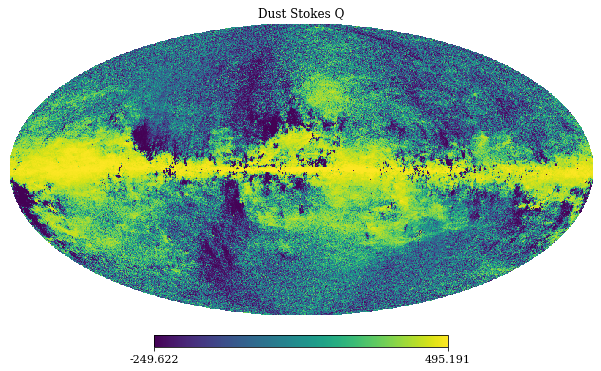

In [33]:
# Stokes Q map of dust
dust_amp_Q = model.components["dust"].amp[1]
mollview(
    dust_amp_Q,
    title='Dust Stokes Q',
    norm="hist",
)

Or use the cosmoglobe "plot" function for direct plotting and formatting of a model.
This function can be used in the same way as mollview, and is a wrapper on the
healpy projview function with some extra features. 

(<matplotlib.collections.QuadMesh at 0x7f804a7b1070>,
 {'data': array([-4.01957718, -1.29835574,  1.69922271, ...,  4.33198759,
         -5.62753956,  0.72578835]),
  'comp': 'dust',
  'sig': 1,
  'rlabel': '$A_d$',
  'llabel': '$Q$',
  'unit': '$\\mu\\mathrm{K}_{\\mathrm{RJ}}\\,@\\,353\\,\\mathrm{GHz}$',
  'ticks': [-100, 0, 100],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'symlog2',
  'norm_dict': {'linthresh': 5},
  'cmap': 'iceburn',
  'freq_ref': <Quantity 353. GHz>,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-100$', '$0$', '$100$']})

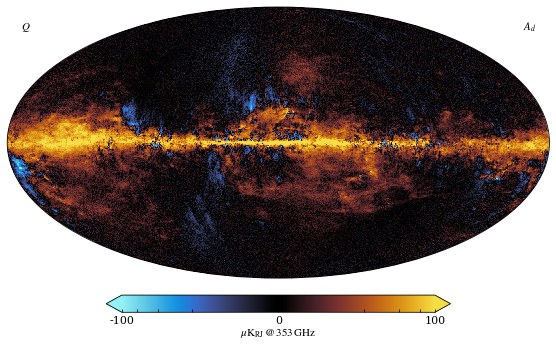

In [34]:
# Pass in the model and specify which component to plot.
plot(model, comp="dust", sig="Q",)


## Simulations

The primary use case of the *cosmoglobe* software is to provide the community with astrophysical maps generated with the Cosmoglobe Sky Model. The mean posterior maps used in the sky model (given at some reference frequency) are directly accessible through model attributes as demonstrated in the above section.

These maps can additionally be extrapolated to arbitrary frequencies to produce simulations of the sky. In the following we look at how we can use *cosmoglobe* to generate full sky simulations:

### Simulating component emission

We can simulate the emission from a component at an arbitrary frequency `freq` by calling the component's `__call__` method, e.g, `model.dust(freq)`.

This function takes in the following key word arguments:

- `freqs` : A frequency, or a list of frequencies for which to evaluate the sky emission

- `bandpass` : Bandpass profile corresponding to the frequencies (*optional*)

- `fwhm` : The full width half max parameter of the Gaussian used to smooth the output (optional)

- `output_unit` : The output units of the emission (By default the output unit of the model is always in uK_RJ

Below, is a simulation of synchrotron emission at $20\;\mathrm{GHz}$:

(<matplotlib.collections.QuadMesh at 0x7f8020251670>,
 {'data': array([93.58164725, 90.38146853, 85.50231773, ..., 76.24776625,
         78.24186881, 79.20658964]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': None,
  'ticks': [49.80404939854137, 1084.5020392865435],
  'min': None,
  'max': None,
  'rng': None,
  'norm': None,
  'norm_dict': None,
  'cmap': 'swamp',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$49$', '$1084$']})

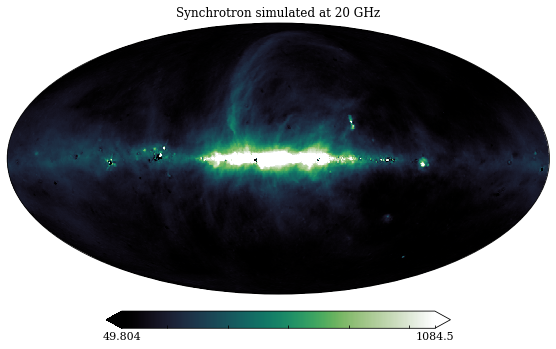

In [35]:
import astropy.units as u  # astropy.units is a package for unit handling

# Simulated synchrotron emission at 20GHz
simulated_emission = model(20*u.GHz, components=["synch"])

plot(
    simulated_emission[0],
    title='Synchrotron simulated at 20 GHz', 
    cmap='swamp',
)

And a simulation of free-free emission at $20\;\mathrm{GHz}$ with a FWHM of $30\;'$ and output units set to $\mathrm{MJy/sr}$:

(<matplotlib.collections.QuadMesh at 0x7f802016db80>,
 {'data': array([ 1.05682988e-04, -5.59499953e-05, -1.05648426e-04, ...,
         -1.31944092e-03, -1.22261591e-03, -1.15828253e-03]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': '$\\mathrm{\\frac{MJy}{sr}}$',
  'ticks': [-0.0013631425254432069, 0.0921634371558297],
  'min': None,
  'max': None,
  'rng': None,
  'norm': None,
  'norm_dict': None,
  'cmap': 'freeze',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-0.0$', '$0.09$']})

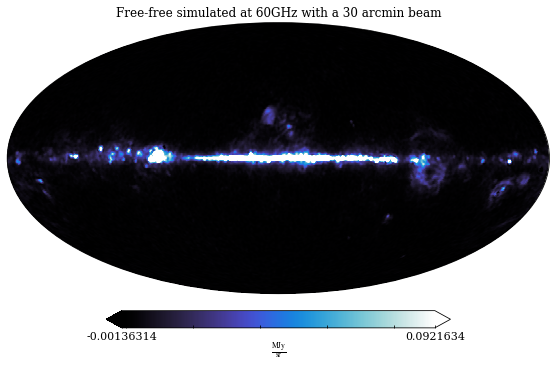

In [36]:
# Simulated free-free emission at 60GHz seen by a 30 arcmin
# beam in units of MJy/sr
simulated_emission = model(
    60*u.GHz, 
    fwhm=30*u.arcmin, 
    output_unit='MJy/sr',
    components=["ff"]
)

plot(
    simulated_emission[0], 
    title='Free-free simulated at 60GHz with a 30 arcmin beam', 
    unit=simulated_emission.unit,
    cmap='freeze',
)


### Simulating model emission

Similarly, by calling the model's `__call__` function (which takes in the same keyword arguments), we can simulate the sky emission over the full model at a given frequency:

(<matplotlib.collections.QuadMesh at 0x7f7fc856b4f0>,
 {'data': array([ 1857.06100303,  1854.47363061,  1871.76044276, ...,
         -1952.45172834, -1940.09037429, -1936.28452927]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': None,
  'ticks': [-3400, 3400],
  'min': -3400,
  'max': 3400,
  'rng': None,
  'norm': None,
  'norm_dict': None,
  'cmap': 'planck',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-3400$', '$3400$']})

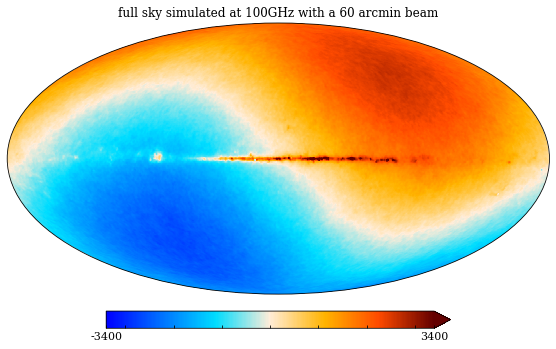

In [37]:
# Simulated full sky emission at 100GHz seen by a 60 arcmin
# beam in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0], 
    title='full sky simulated at 100GHz with a 60 arcmin beam',  
    min=-3400,
    max=3400,
)


It is possible to remove the solar dipole from the model, by calling `model.cmb.remove_dipole()`:

(<matplotlib.collections.QuadMesh at 0x7f8056c5cbe0>,
 {'data': array([-76.37011282, -79.74717809, -70.26625067, ...,  11.3845686 ,
          15.94003791,  20.53557578]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': None,
  'ticks': [-300, 300],
  'min': -300,
  'max': 300,
  'rng': None,
  'norm': None,
  'norm_dict': None,
  'cmap': 'planck',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-300$', '$300$']})

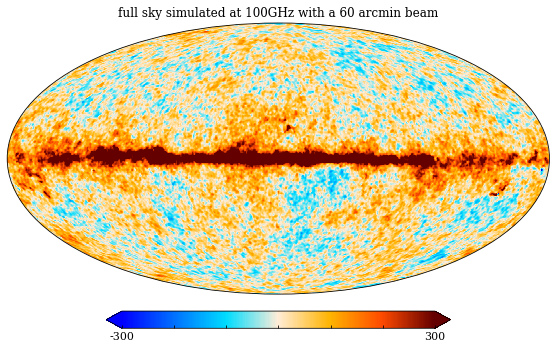

In [38]:
# Remove the solar dipole
model.remove_dipole()

# Simulated full sky emission at 100GHz seen by a 60 arcmin
# beam in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0], 
    title='full sky simulated at 100GHz with a 60 arcmin beam', 
    min=-300,
    max=300,
)


### Bandpass integration

We can also make simulations that have integrated the sky emission over a given bandpass. By default 
if only a list of frequencies are supplied without an explicit bandpass input, a top-hat bandpass will be used during the integration.

(<matplotlib.collections.QuadMesh at 0x7f804ff81040>,
 {'data': array([-69.07164031, -80.50819514, -74.77978502, ...,  21.37857762,
          35.67817327,  39.27271206]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': None,
  'ticks': [-117.32857341383954, 750.4833935506042],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'hist',
  'norm_dict': None,
  'cmap': 'planck',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-117$', '$750$']})

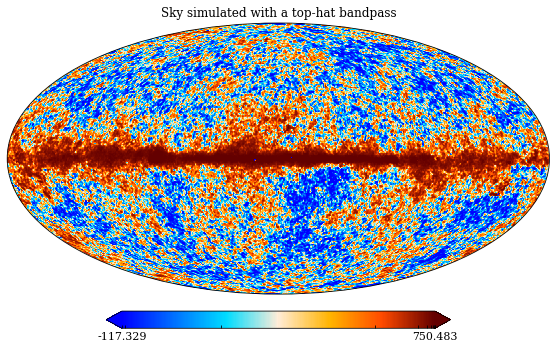

In [39]:
import numpy as np

frequencies = np.arange(100, 110, 50)*u.GHz

simulated_emission = model(frequencies, fwhm=40*u.arcmin)

plot(
    simulated_emission[0], 
    title='Sky simulated with a top-hat bandpass', 
    norm='hist',
)

In the following we use the WMAP K-band bandpass profile:

In [46]:
bandpass = path+"wmap_bandpass.txt"
frequencies, bandpass, _ = np.loadtxt(bandpass, unpack=True)

#add astropy units to the bandpass
frequencies*= u.GHz
bandpass *= u.Unit("K_RJ")

Note that when we are working with bandpasses, we give the bandpass unit (even if it is normalized) to differentiate bandpasses measured in K_CMB and K_RJ units. Importing the cosmoglobe model allow us to use `u.Unit("K_RJ")` and `u.Unit("K_CMB")` to explicitly state which unit we need.

(<matplotlib.collections.QuadMesh at 0x7f8052702cd0>,
 {'data': array([-0.0069367 , -0.02060602, -0.01526639, ...,  0.02398448,
          0.03608212,  0.04311066]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': '$\\mathrm{mK_{{RJ}}}$',
  'ticks': [-0.04602656430781337, 10.310317464575249],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'hist',
  'norm_dict': None,
  'cmap': 'planck',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-0.05$', '$10$']})

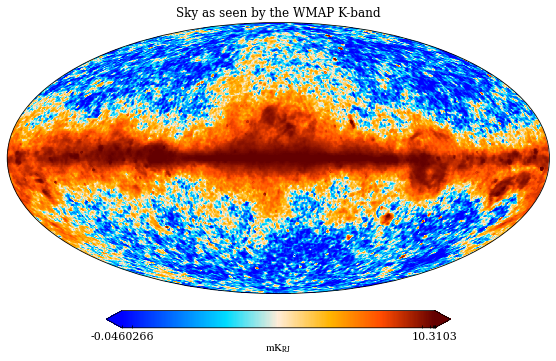

In [47]:
# Note: Solar dipole is removed from the model
wmap_kband_emission = model(
    frequencies, 
    bandpass, 
    fwhm=0.88*u.deg, 
    output_unit='mK_RJ'
)

plot(
    wmap_kband_emission[0], 
    title='Sky as seen by the WMAP K-band', 
    unit=wmap_kband_emission.unit,
    norm='hist',
)

## Point sources

The radio component does not store HEALPIX amplitude maps internally. Instead, the *amp* quantity contains a list of amplitude values, one per point source. Each source is then mapped to a HEALPIX map with a truncated gaussian beam whenever the model (or radio component) is called.

(<matplotlib.collections.QuadMesh at 0x7f80548037c0>,
 {'data': array([0.03262944, 0.06934092, 0.06042835, ..., 0.11145901, 0.025511  ,
         0.06111052]),
  'comp': None,
  'sig': 0,
  'rlabel': None,
  'llabel': None,
  'unit': None,
  'ticks': [0.0, 155.27530458805415],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'hist',
  'norm_dict': None,
  'cmap': 'CMRmap',
  'freq_ref': None,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$0$', '$155$']})

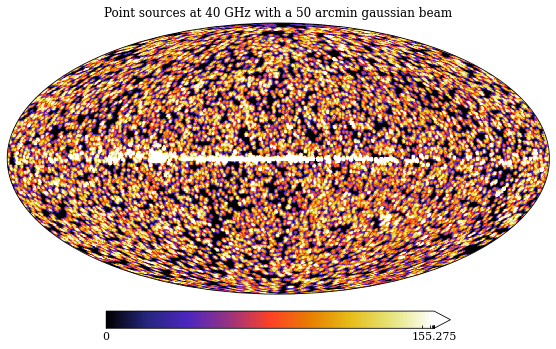

In [42]:
# Point sources seen at 40GHz over a 50 arcmin gaussian beam
simulated_emission = model(30*u.GHz, fwhm=50*u.arcmin, components=["radio"])

plot(
    simulated_emission[0], 
    title='Point sources at 40 GHz with a 50 arcmin gaussian beam', 
    norm='hist', 
    cmap='CMRmap'
)

## Plotting

In addition to the features already displayed previously in this tutorial, the 
`plot` function has a lot more new functionality.

Similar to available plotting scripts such as healpy's `mollview`, `plot` allows
for direct plotting of map-arrays. However, it also supports direct plotting of
cosmoglobe model objects and direct reading of fits files. 

Another defining feature of the code is the automatic parameter setting defined
specifically for each sky component for the ultimate viewing pleasure, set by
specifying the `comp` input. 

Other useful features include direct smoothing, ud_grading and mono-dipole
removal of the passed maps.

Here are some examples:


(<matplotlib.collections.QuadMesh at 0x7f804e9cc9a0>,
 {'data': array([ -5.10686449,  12.55576019,  -3.41984734, ..., -17.241101  ,
          20.72343412,  -2.33641607]),
  'comp': 'freqmap',
  'sig': 1,
  'rlabel': '$A_{30}$',
  'llabel': '$Q$',
  'unit': '$\\mu\\mathrm{K}\\,@\\,30\\,\\mathrm{GHz}$',
  'ticks': [-100.0, -10, 0, 10, 1000.0, 1000000.0],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'symlog2',
  'norm_dict': None,
  'cmap': 'planck_log',
  'freq_ref': <Quantity 30. GHz>,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-100$', '$-10$', '$0$', '$10$', '$1000$', '$10^{6}$']})

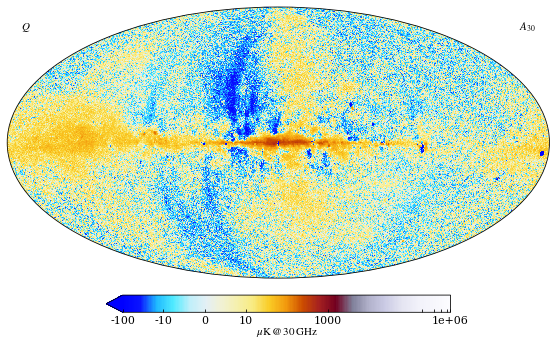

In [43]:
plot(model, freq=30*u.GHz, sig="Q")

(<matplotlib.collections.QuadMesh at 0x7f805280e970>,
 {'data': array([-0.31644916, -0.11476952, -0.3912375 , ...,  0.01459645,
          0.10885113, -0.0720675 ]),
  'comp': 'radio',
  'sig': 0,
  'rlabel': '$A_{\\mathrm{ptsrc}}$',
  'llabel': '$I$',
  'unit': '$\\mu\\mathrm{K}_{\\mathrm{RJ}}\\,@\\,30\\,\\mathrm{GHz}$',
  'ticks': [-0.31699661232736154, 128.0551097852748],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'symlog2',
  'norm_dict': {'linthresh': 5},
  'cmap': 'CMRmap',
  'freq_ref': <Quantity 30. GHz>,
  'width': 8.302200083022,
  'nside': 256,
  'ticklabels': ['$-0.32$', '$128$']})

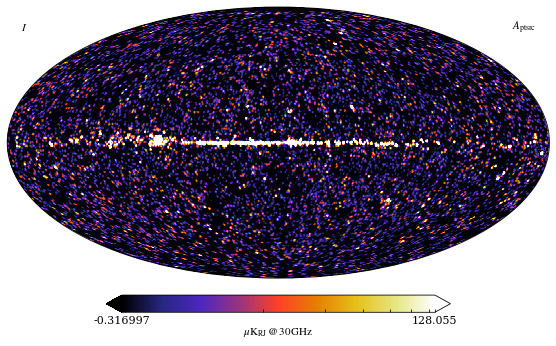

In [44]:
plot(model, comp="radio", fwhm=30*u.arcmin)

(<matplotlib.collections.QuadMesh at 0x7f8056cf99a0>,
 {'data': array([20.05815479,  7.049298  ,  3.61007396, ..., 22.9471769 ,
         17.30836798, 21.17100985]),
  'comp': 'dust',
  'sig': 0,
  'rlabel': '$A_d$',
  'llabel': '$I$',
  'unit': '$\\mu\\mathrm{K}_{\\mathrm{RJ}}$',
  'ticks': [30, 300, 3000],
  'min': None,
  'max': None,
  'rng': None,
  'norm': 'symlog2',
  'norm_dict': {'linthresh': 5},
  'cmap': 'sunburst',
  'freq_ref': 545.0,
  'width': 8.302200083022,
  'nside': 1024,
  'ticklabels': ['$30$', '$300$', '$3000$']})

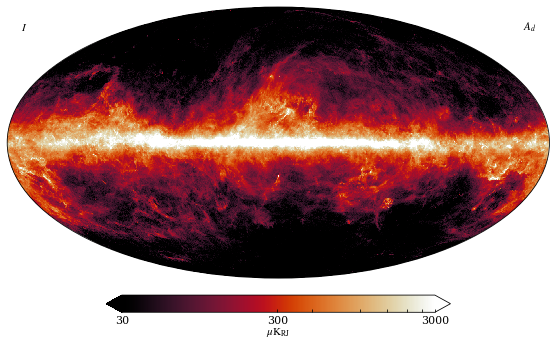

In [45]:
fits_filename = path+"dust_c0001_k000200.fits"
plot(fits_filename, comp="dust")